# Adjusted Salary Analysis
___

**Objective**: The purpose of this notebook is to understand how salary has been adjusting over the past few years to attempt to overcome the model limitation of working only for 2023. It could use oficial inflation rates or adjustments to the minimum wage, but maybe the most simple and straightforward approach is to utilize the avarage salary change.

**Process:**
1. Data Collection
2. EDA + Simple Feature Engineering (Dummy year, lag variable, % change YoY, etc)
3. Fitting a simple model
_______

## 1. Data Collection

Data can be collected from Base dos Dados public datalake on BigQuery using a simple SQL aggregation:

In [1]:
# Import needed library
import basedosdados as bd

# Define SQL query and billing_project_id
sql_query = """
SELECT
    ano AS year
    , AVG(VD4019) AS avg_salary
FROM 
    basedosdados.br_ibge_pnadc.microdados
WHERE
    VD4015 <> '2' -- excludes people not payed in money for their work
GROUP BY
    ano
ORDER BY
    ano ASC
"""
billing_project_id = "incomeprediction-425511"

# Collect data and show it
df = bd.read_sql(query=sql_query, billing_project_id=billing_project_id)
df

Downloading: 100%|██████████| 12/12 [00:00<00:00, 39.26rows/s]


,year,avg_salary
0,2012,1316.023423
1,2013,1443.788456
2,2014,1550.742136
3,2015,1657.595888
4,2016,1756.330242
5,2017,1875.784540
6,2018,1968.171949
7,2019,2055.721865
8,2020,2224.109341
9,2021,2231.132862


With the data already saved in a dedicated variable, let's move on the EDA:
___

## 2. EDA and Simple Feature Engineering:

Importing needed libraries and plotting an initial line chart:

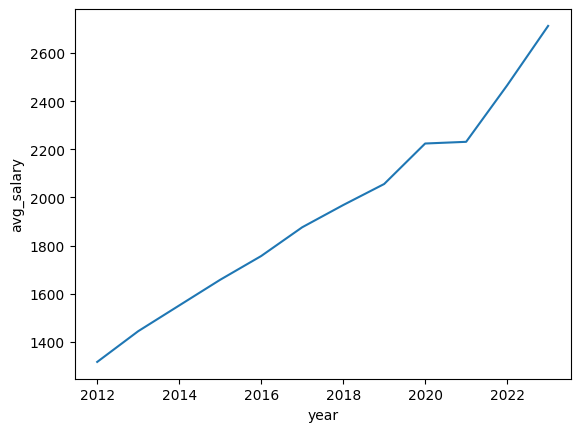

In [2]:
# Needed libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Line Chart
sns.lineplot(data=df, x='year', y='avg_salary')
plt.show()

Almost a straight line, althought it had some fluctuation after 2019.

Let's the check the spearman correlation:

In [3]:
from scipy.stats import spearmanr

corr, pvalue = spearmanr(df['year'], df['avg_salary'])
print(f'Spearman Correlation: {corr: .2f}')
print(f'P-value: {pvalue: .3f}')

Spearman Correlation:  1.00
P-value:  0.000


No more feature engineering needed.   
A simple linear model with a small regularization should be enough for this project.
____

## 3. Fitting a Simple Linear Model:

In [4]:
# Import
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Train
X = df[['year']]
y = df[['avg_salary']]
model = Ridge()
model.fit(X, y)

# Predict
pred = model.predict(X)

# Initial evaluation
print(f'R²: {model.score(X, y): .3f}')
print(f'MAE: R$ {mean_absolute_error(y, pred) :.2f}')
print(f'Coef: R$ {model.coef_[0][0] :.2f}')

R²:  0.981
MAE: R$ 34.75
Coef: R$ 115.11


This means that, on average, salary increases R$ 115 each year.   
Since R² is still nearly 1, the MAE is close to 0

Let's visualize fit in a chart to understand results:

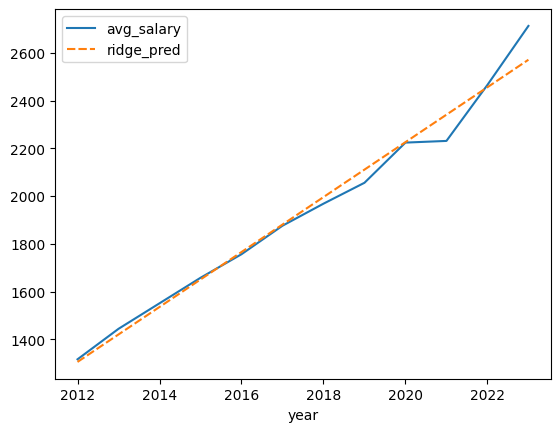

In [5]:
# Prepare to plot multiple lines
df['ridge_pred'] = pred
df.index = df['year']
df.drop('year', axis=1, inplace=True)

# Plot line chart
sns.lineplot(df)
plt.show()

In summary, if we consider the training point as the intercept and plug in the linear equation, we will have:

    adjusted prediction = years from 2023 * coeficient + 2023 prediction

where coeficient is approximately R$ 115.11

In [6]:
# Obtaining final estimated value for the coeficient:
model.coef_[0][0]

115.10836311843748